In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
fld = '/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/'
ds = xr.open_dataset(fld + '/T_008S_095W_COARE3p5_1999_2009_2hrMeanVar_QS_Buoy_Glorys_Wave_Matchup.nc')
                     #T_009N_140W_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc')
#ds = xr.open_dataset(fld + 'T_005S_140W_COARE3p5_1999_2009_2hrMeanVar_QS_Matchup.nc')
ds

<xarray.Dataset> Size: 10MB
Dimensions:                           (QS_TIME: 6873, cross_track: 3,
                                       ambiguities: 4, HEIGHT: 3, DEPTH: 1)
Coordinates:
  * QS_TIME                           (QS_TIME) datetime64[ns] 55kB 1999-11-2...
  * cross_track                       (cross_track) int64 24B 0 1 2
  * ambiguities                       (ambiguities) int64 32B 0 1 2 3
  * HEIGHT                            (HEIGHT) float32 12B 3.0 4.0 10.0
  * DEPTH                             (DEPTH) float32 4B 1.0
Data variables: (12/95)
    retrieved_wind_speed              (QS_TIME, cross_track) float64 165kB ...
    retrieved_wind_direction          (QS_TIME, cross_track) float64 165kB ...
    rain_impact                       (QS_TIME, cross_track) float64 165kB ...
    flags                             (QS_TIME, cross_track) float64 165kB ...
    eflags                            (QS_TIME, cross_track) float64 165kB ...
    nudge_wind_speed                  (QS_TIME, cross_track) float64 165kB ...
    ...                                ...
    vo                                (QS_TIME) float64 55kB ...
    zos                               (QS_TIME) float64 55kB ...
    uo                                (QS_TIME) float64 55kB ...
    thetao                            (QS_TIME) float64 55kB ...
    so                                (QS_TIME) float64 55kB ...
    GLORYS_TIME                       (QS_TIME) datetime64[ns] 55kB ...

In [3]:
print(list(np.unique(ds.WSPD_QC.to_numpy())))
print(list(np.unique(ds.WDIR_QC.to_numpy())))
print(list(np.unique(ds.SST_QC.to_numpy())))
print(list(np.unique(ds.RELH_QC.to_numpy())))
print(list(np.unique(ds.AIRT_QC.to_numpy())))                                                                                                                                                                                          

[np.float32(2.0), np.float32(nan)]
[np.float32(2.0), np.float32(nan)]
[np.float32(2.0)]
[np.float32(2.0), np.float32(nan)]
[np.float32(2.0), np.float32(nan)]


In [4]:
list(ds.variables.keys())

['QS_TIME',
 'cross_track',
 'retrieved_wind_speed',
 'retrieved_wind_direction',
 'rain_impact',
 'flags',
 'eflags',
 'nudge_wind_speed',
 'nudge_wind_direction',
 'retrieved_wind_speed_uncorrected',
 'cross_track_wind_speed_bias',
 'atmospheric_speed_bias',
 'wind_obj',
 'ambiguities',
 'ambiguity_speed',
 'ambiguity_direction',
 'ambiguity_obj',
 'number_in_fore',
 'number_in_aft',
 'number_out_fore',
 'number_out_aft',
 'gmf_sst',
 'distance_from_coast',
 'exp_bias_wrt_oceanward_neighbors',
 'dist_from_TAO_pos',
 'HEIGHT',
 'DEPTH',
 'WDIR',
 'WDIR_QC',
 'WDIR_DM',
 'WSPD',
 'WSPD_QC',
 'WSPD_DM',
 'UWND',
 'VWND',
 'SST',
 'SST_QC',
 'SST_DM',
 'AIRT',
 'AIRT_QC',
 'AIRT_DM',
 'RELH',
 'RELH_QC',
 'RELH_DM',
 'WSPD_10N',
 'WSPD_10',
 'SST - AIRT',
 'cosWDIR',
 'sinWDIR',
 'U10N_x',
 'U10N_y',
 'mean_WSPD',
 'std_WSPD',
 'mean_WDIR',
 'std_WDIR',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_U10N_x',
 'std_U10N_x',
 'me

In [7]:
def getSubDF(ds, LAT, LON):
    LON = (LON+360)%360
        
    subds = xr.Dataset()

    taoTimeVar = ['TAO_TIME']
    
    windVars = ['WDIR',
         'WDIR_QC',
         'WDIR_DM',
         'WSPD',
         'WSPD_QC',
         'WSPD_DM',
         'UWND',
         'VWND']

    sstVars = ['SST',
             'SST_QC',
             'SST_DM']
    
    airtVars = ['AIRT',
             'AIRT_QC',
             'AIRT_DM']
    
    rhVars = ['RELH',
             'RELH_QC',
             'RELH_DM']
    
    u10Vars =['WSPD_10N',
             'WSPD_10']

    statVars= [f'mean_WSPD',
               f'std_WSPD',
               f'mean_WSPD_10N',
               f'std_WSPD_10N',
               f'mean_U10N_x',
               f'std_U10N_x',
               f'mean_U10N_y',
               f'std_U10N_y',
               f'mean_WDIR',
               f'std_WDIR',
               f'mean_cosWDIR',
               f'std_cosWDIR',
               f'mean_sinWDIR',
               f'std_sinWDIR',
               f'mean_SST',
               f'std_SST',
               f'mean_AIRT',
               f'std_AIRT',
               f'mean_SST - AIRT',
               f'std_SST - AIRT',
               f'mean_RELH',
               f'std_RELH',]
    
    
    satVars = ['retrieved_wind_speed',
             'retrieved_wind_direction',
             'rain_impact',
             'flags',
             'eflags',
             'nudge_wind_speed',
             'nudge_wind_direction',
             'retrieved_wind_speed_uncorrected',
             'cross_track_wind_speed_bias',
             'atmospheric_speed_bias',
             'wind_obj',
             'number_in_fore',
             'number_in_aft',
             'number_out_fore',
             'number_out_aft',
             'gmf_sst',
             'distance_from_coast',
             'exp_bias_wrt_oceanward_neighbors']

    satAmbVars =['ambiguity_obj',
                 'ambiguity_speed',
                 'ambiguity_direction']

    waveVars = ['VHM0',
                 'VHM0_SW1',
                 'VHM0_SW2',
                 'VHM0_WW',
                 'VMDR',
                 'VMDR_SW1',
                 'VMDR_SW2',
                 'VMDR_WW',
                 'VPED',
                 'VSDX',
                 'VSDY',
                 'VTM01_SW1',
                 'VTM01_SW2',
                 'VTM01_WW',
                 'VTM02',
                 'VTM10',
                 'VTPK',
                 'WAVE_TIME']

    oceanVars = ['vo',
                 'zos',
                 'uo',
                 'thetao',
                 'so',
                 'GLORYS_TIME']

     
    
    for windVar in windVars:
        subds[windVar] = ds[windVar].sel(HEIGHT=4)
    subds.drop_vars('HEIGHT')
    for sstVar in sstVars:
        subds[sstVar] = ds[sstVar].sel(DEPTH=1)
    subds.drop_vars('DEPTH')
    for rhVar in rhVars:
        subds[rhVar] = ds[rhVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for airtVar in airtVars:
        subds[airtVar] = ds[airtVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for u10Var in u10Vars:
        subds[u10Var] = ds[u10Var].sel(HEIGHT=10)
    subds.drop_vars('HEIGHT')


    for var in waveVars:
        subds[var] = ds[var]

    for var in oceanVars:
        subds[var] = ds[var]

    for statVar in statVars:
        subds[statVar] = ds[statVar]

    subds['LATITUDE'] = xr.DataArray(LAT * np.ones(len(subds['QS_TIME']), dtype = float), dims=['QS_TIME'])
    subds['LONGITUDE'] = xr.DataArray(LON * np.ones(len(subds['QS_TIME']), dtype = float), dims=['QS_TIME'])
    
    subds['TAO_TIME'] = ds['TAO_TIME']

    deployFileName = f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = xr.open_dataset(deployFileName)
    startDates = np.array(ds2['startDate'])
    endDates = np.array(ds2['endDate'])

    depNum = np.zeros((len(subds['QS_TIME'])), dtype=int)
    c = 1
    for i in range(1,len(startDates)):
        mask = subds['QS_TIME'] >= startDates[i]
        mask *= subds['QS_TIME'] <= endDates[i]
        depNum[mask] = c
        c = c+1

    subds['Deployment index'] = xr.DataArray(depNum, dims=['QS_TIME'])
    
    satDS = ds[satVars]
    satDS = satDS.isel(cross_track=0)

    amb_speed = ds['ambiguity_speed'].isel(cross_track=0).to_numpy()
    num_amb_speed = np.sum(np.isnan(amb_speed), axis = 1)
    subds['num_ambiguities_speed'] = xr.DataArray(num_amb_speed, dims=['QS_TIME'])

    amb_direction = ds['ambiguity_direction'].isel(cross_track=0).to_numpy()
    num_amb_direction = np.sum(np.isnan(amb_direction), axis = 1)
    subds['num_ambiguities_direction'] = xr.DataArray(num_amb_direction, dims=['QS_TIME'])

    
    sat0DS = ds[satAmbVars].isel(cross_track=0, ambiguities=0).drop_vars(['ambiguities'])
    sat0DS = sat0DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_0',
                                 'ambiguity_direction': 'ambiguity_direction_0', 
                                 'ambiguity_obj': 'ambiguity_obj_0'})

    sat1DS = ds[satAmbVars].isel(cross_track=0, ambiguities=1).drop_vars(['ambiguities'])
    sat1DS = sat1DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_1',
                        'ambiguity_direction': 'ambiguity_direction_1', 
                                 'ambiguity_obj': 'ambiguity_obj_1'})

    sat2DS = ds[satAmbVars].isel(cross_track=0, ambiguities=2).drop_vars(['ambiguities'])
    sat2DS = sat2DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_2',
                        'ambiguity_direction': 'ambiguity_direction_2', 
                                 'ambiguity_obj': 'ambiguity_obj_2'})

    sat3DS = ds[satAmbVars].isel(cross_track=0, ambiguities=3).drop_vars(['ambiguities'])
    sat3DS = sat3DS.rename_vars({'ambiguity_speed': 'ambiguity_speed_3',
                        'ambiguity_direction': 'ambiguity_direction_3', 
                                 'ambiguity_obj': 'ambiguity_obj_3'})
    returnDS = xr.merge((subds, satDS, sat0DS, sat1DS, sat2DS, sat3DS))

    
    
    return returnDS

In [8]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)


allDS = xr.Dataset()
dataCount = 0
fileCount = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'

    #LON = (LON+360)%360
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_1999_2009_2hrMeanVar_QS_Buoy_Glorys_Wave_Matchup.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        print(f'T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}')
        rds = xr.open_dataset(matchFname)
        ds = getSubDF(rds, LAT, LON)
        QS_TIME = ds['QS_TIME'].to_numpy()
        ds = ds.rename({'QS_TIME':'count'})
        dataLen = len(ds['count'])
        print(dataCount, dataCount+dataLen)
        ds['count'] = xr.DataArray(pd.Series(np.arange(dataCount, dataCount+dataLen)), 
                                   dims = ['count'])
        ds['QS_TIME'] = xr.DataArray(QS_TIME, 
                                   dims = ['count'])
        dataCount += dataLen
        if fileCount == 0:
            allDS = ds
        else:
            allDS = xr.concat((allDS, ds), dim='count')
        fileCount += 1
        

T_008S_095W
0 6873
T_008S_110W
6873 10793
T_008S_125W
10793 16169
T_008S_155W
16169 21215
T_008S_170W
21215 27563
T_008S_180W
27563 33070
T_008S_165E
33070 37659
T_005S_095W
37659 42726
T_005S_110W
42726 48079
T_005S_125W
48079 54914
T_005S_140W
54914 62307
T_005S_155W
62307 66062
T_005S_170W
66062 70183
T_005S_180W
70183 76109
T_005S_165E
76109 83610
T_002S_095W
83610 85109
T_002S_110W
85109 87791
T_002S_125W
87791 95162
T_002S_140W
95162 101700
T_002S_155W
101700 107215
T_002S_170W
107215 111620
T_002S_180W
111620 119195
T_002S_165E
119195 122594
T_000N_095W
122594 125976
T_000N_110W
125976 130471
T_000N_125W
130471 136017
T_000N_140W
136017 144031
T_000N_155W
144031 151586
T_000N_170W
151586 157952
T_000N_180W
157952 162653
T_000N_165E
162653 166137
T_002N_095W
166137 169464
T_002N_110W
169464 174302
T_002N_125W
174302 178099
T_002N_140W
178099 185780
T_002N_155W
185780 193450
T_002N_170W
193450 197692
T_002N_180W
197692 203173
T_002N_165E
203173 207184
T_005N_095W
207184 211786
T_0

In [9]:
allDS = allDS.drop_vars(['HEIGHT','DEPTH','cross_track'])

In [10]:
allDS

<xarray.Dataset> Size: 221MB
Dimensions:                           (count: 298066)
Coordinates:
  * count                             (count) int64 2MB 0 1 2 ... 298064 298065
Data variables: (12/102)
    WDIR                              (count) float32 1MB 140.6 129.4 ... 227.3
    WDIR_QC                           (count) float32 1MB 2.0 2.0 ... 2.0 2.0
    WDIR_DM                           (count) |S1 298kB b'D' b'D' ... b'D' b'D'
    WSPD                              (count) float32 1MB 6.79 5.46 ... 1.47
    WSPD_QC                           (count) float32 1MB 2.0 2.0 ... 2.0 2.0
    WSPD_DM                           (count) |S1 298kB b'D' b'D' ... b'D' b'D'
    ...                                ...
    ambiguity_speed_2                 (count) float64 2MB nan 10.65 ... 2.075
    ambiguity_direction_2             (count) float64 2MB nan 244.5 ... 259.7
    ambiguity_obj_3                   (count) float64 2MB nan nan ... -9.501 nan
    ambiguity_speed_3                 (count) float64 2MB nan nan ... 1.75 nan
    ambiguity_direction_3             (count) float64 2MB nan nan ... 307.0 nan
    QS_TIME                           (count) datetime64[ns] 2MB 1999-11-24T1...

In [11]:
flag_meanings = allDS.flags.flag_meanings.strip().split(' ')
flag_vals = np.array( [ val.strip().rstrip('s') for val in allDS.flags.flag_masks.split(',')], dtype=int)
significant_bit = np.log2(flag_vals)
position_from_left = 15- significant_bit

for i,j in zip(position_from_left, flag_meanings):
    print(f'{i:3.0f} {j}')


 15 adequate_sigma0_flag
 14 adequate_azimuth_diversity_flag
 10 poor_coastal_processing_flag
  9 wind_retrieval_likely_corrupted_flag
  8 coastal_flag
  7 ice_edge_flag
  6 winds_not_retrieved_flag
  5 high_wind_speed_flag
  4 low_wind_speed_flag
  3 rain_impact_flag_not_usable_flag
  2 rain_impact_flag
  1 missing_look_flag


In [12]:
eflag_meanings = allDS.eflags.flag_meanings.strip().split(' ')
eflag_vals = np.array( [ val.strip().rstrip('s') for val in allDS.eflags.flag_masks.split(',')], dtype=int)
significant_bit = np.log2(eflag_vals)
position_from_left = 15- significant_bit

for i,j in zip(position_from_left, eflag_meanings):
    print(f'{i:3.0f} {j}')

 15 rain_correction_not_applied_flag
 14 correction_produced_negative_spd_flag
 13 all_ambiguities_contribute_to_nudging_flag
 12 large_rain_correction_flag
 11 coastal_processing_applied_flag
  9 lake_winds_flag
  7 rain_nearby_flag
  6 ice_nearby_flag
  5 significant_rain_correction_flag
  4 rain_correction_applied_flag
  3 wind_retrieval_possibly_corrupted_flag


In [13]:
eflags_dummy = allDS['eflags'].to_numpy()
eflags_dummy[np.isnan(eflags_dummy)] = 0
extended_flags = np.array(eflags_dummy, dtype=int)
eflags = np.array(['{:016b}'.format(val) for val in extended_flags])

flags_dummy = allDS['eflags'].to_numpy()
flags_dummy[np.isnan(eflags_dummy)] = 0
flags = np.array(flags_dummy, dtype=int)
flags = np.array(['{:016b}'.format(val) for val in flags])

rain_impact_flag_not_usable_flag = np.array([val[3] == '1' for val in flags])
rain_impact_flag = np.array([val[2] == '1' for val in flags])
rainCorrectionApplied = np.array([val[4] == '1' for val in eflags])
significantRainCorrectionApplied = np.array([val[5] == '1' for val in eflags])
largeRainCorrectionApplied = np.array([val[12] == '1' for val in eflags])

rainMask = np.logical_or(rainCorrectionApplied, significantRainCorrectionApplied)
rainMask = np.logical_or(rainMask, largeRainCorrectionApplied)
rainmask = np.logical_or(rainMask, rain_impact_flag)
rainmask = np.logical_or(rainMask, rain_impact_flag_not_usable_flag)
allDS['rainFlag'] = xr.DataArray(np.array(rainMask, dtype=int), dims=['count'])

In [14]:
np.unique(allDS['eflags'].to_numpy())

array([0.000e+00, 1.000e+00, 5.000e+00, 2.100e+01, 2.052e+03, 4.097e+03,
       4.101e+03, 4.117e+03, 4.119e+03, 4.353e+03, 4.357e+03, 4.373e+03,
       4.375e+03, 6.404e+03, 7.172e+03, 7.180e+03, 7.182e+03, 7.428e+03,
       7.436e+03, 7.438e+03])

In [15]:
noRainMask = ~rainMask
mask1 = allDS['WSPD_QC'].isin([1,2]).to_numpy()
mask2 = allDS['WDIR_QC'].isin([1,2]).to_numpy()
mask3 = allDS['SST_QC'].isin([1,2]).to_numpy()
mask4 = allDS['RELH_QC'].isin([1,2]).to_numpy()
mask5 = allDS['AIRT_QC'].isin([1,2]).to_numpy()

In [16]:
selectMask = np.logical_and(noRainMask, mask1)
selectMask = np.logical_and(selectMask, mask2)
selectMask = np.logical_and(selectMask, mask3)
selectMask = np.logical_and(selectMask, mask4)
selectMask = np.logical_and(selectMask, mask5)

In [17]:
indices = selectMask.nonzero()[0]
goodDataSet = allDS.sel(count=indices)

In [18]:
varList = list(goodDataSet.variables.keys())
varList = ['WSPD', 'WDIR', 'SST', 'RELH', 'AIRT',
           'mean_WSPD', 'mean_WDIR', 'mean_SST', 'mean_RELH', 'mean_AIRT', 'mean_SST - AIRT',
           'std_WSPD', 'std_WDIR', 'std_SST', 'std_RELH', 'std_AIRT', 'std_SST - AIRT',
           'std_cosWDIR', 'std_sinWDIR',
           'std_U10N_x','std_U10N_y',
           'retrieved_wind_speed', 'retrieved_wind_direction']

var = varList[0]
mask = np.isnan(goodDataSet[var].to_numpy())
print(var, np.sum(mask))

for var in varList[1::]:
    old = np.sum(mask)
    mask = np.logical_or(mask, np.isnan(goodDataSet[var].to_numpy()))
    print(var, np.sum(mask) - old)

print('total', np.sum(mask))



df = goodDataSet.isel(count = ~mask)
len(df['count'].values)
#df = df.to_dataframe()

WSPD 0
WDIR 0
SST 0
RELH 0
AIRT 0
mean_WSPD 975
mean_WDIR 0
mean_SST 0
mean_RELH 0
mean_AIRT 0
mean_SST - AIRT 0
std_WSPD 0
std_WDIR 0
std_SST 2122
std_RELH 9
std_AIRT 0
std_SST - AIRT 0
std_cosWDIR 6
std_sinWDIR 0
std_U10N_x 0
std_U10N_y 0
retrieved_wind_speed 17652
retrieved_wind_direction 0
total 20764


266786

In [19]:
goodDataSet = goodDataSet.rename_vars({'WSPD':'WSPD (TAO)',
                  'WDIR':'WDIR (TAO)',
                  'UWND': 'UWND (TAO)',
                  'VWND': 'VWND (TAO)',
                  'SST': 'SST (TAO)',
                  'RELH': 'RELH (TAO)',
                  'AIRT': 'AIRT (TAO)',
                  'WSPD_10N': 'WSPD_10N (TAO)',
                  'WSPD_10': 'WSPD_10 (TAO)',
                  'retrieved_wind_speed': 'WSPD_10N (QuikSCAT)',
                  'retrieved_wind_direction': 'WDIR (QuikSCAT)',
                  'mean_U10N_x': 'mean_UWND_10N', 
                  'mean_U10N_y': 'mean_VWND_10N',
                  'std_U10N_x': 'std_UWND_10N', 
                  'std_U10N_y': 'std_VWND_10N',})

In [20]:
df = df.rename_vars({'WSPD':'WSPD (TAO)',
                  'WDIR':'WDIR (TAO)',
                  'UWND': 'UWND (TAO)',
                  'VWND': 'VWND (TAO)',
                  'SST': 'SST (TAO)',
                  'RELH': 'RELH (TAO)',
                  'AIRT': 'AIRT (TAO)',
                  'WSPD_10N': 'WSPD_10N (TAO)',
                  'WSPD_10': 'WSPD_10 (TAO)',
                  'retrieved_wind_speed': 'WSPD_10N (QuikSCAT)',
                  'retrieved_wind_direction': 'WDIR (QuikSCAT)',
                  'mean_U10N_x': 'mean_UWND_10N', 
                  'mean_U10N_y': 'mean_VWND_10N',
                  'std_U10N_x': 'std_UWND_10N', 
                  'std_U10N_y': 'std_VWND_10N',})

In [21]:
df['WSPD_DIFF (QuikSCAT - TAO)'] = df['WSPD_10N (QuikSCAT)'] - df['WSPD_10N (TAO)']

## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#df['WDIR (TAO)'] = (-(df['WDIR (TAO)'] - 90.0) + 360)%360
df['WDIR (QuikSCAT)'] = (-(df['WDIR (QuikSCAT)'] - 90.0) + 360)%360

## calculate zonal and meridional winds 
df['UWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.cos(np.deg2rad(df['WDIR (TAO)']))
df['VWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.sin(np.deg2rad(df['WDIR (TAO)']))

df['UWND_10N (QuikSCAT)'] = df['WSPD_10N (QuikSCAT)'] * np.cos(np.deg2rad(df['WDIR (QuikSCAT)']))
df['VWND_10N (QuikSCAT)'] = df['WSPD_10N (QuikSCAT)'] * np.sin(np.deg2rad(df['WDIR (QuikSCAT)']))

#### Speed and direction QS corrected to absolute using GLORYS
df['UWND (QuikSCAT) absolute'] = df['UWND_10N (QuikSCAT)'] + df['uo']
df['VWND (QuikSCAT) absolute'] = df['VWND_10N (QuikSCAT)'] + df['vo']

absolute_direction_QS = np.rad2deg(np.arctan2(df['VWND (QuikSCAT) absolute'],
                                              df['UWND (QuikSCAT) absolute']))

absolute_direction_QS = (absolute_direction_QS+360)%360

df['WDIR (QuikSCAT) absolute'] = absolute_direction_QS

## direction diff in range (-180,180)
dirDiff = ((df['WDIR (QuikSCAT)'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (QuikSCAT - TAO)'] = dirDiff
df['cos(WDIR_DIFF (QuikSCAT - TAO))'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (QuikSCAT - TAO))'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (QuikSCAT - TAO)'] = df['UWND_10N (QuikSCAT)'] - df['UWND_10N (TAO)']
df['VWND_DIFF (QuikSCAT - TAO)'] = df['VWND_10N (QuikSCAT)'] - df['VWND_10N (TAO)']

## direction diff in range (-180,180) with absolute
dirDiff = ((df['WDIR (QuikSCAT) absolute'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (QuikSCAT - TAO) absolute'] = dirDiff
df['cos(WDIR_DIFF (QuikSCAT - TAO)) absolute'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (QuikSCAT - TAO)) absolute'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (QuikSCAT - TAO) absolute'] = df['UWND (QuikSCAT) absolute'] - df['UWND_10N (TAO)']

df['VWND_DIFF (QuikSCAT - TAO) absolute'] = df['VWND (QuikSCAT) absolute'] - df['VWND_10N (TAO)']


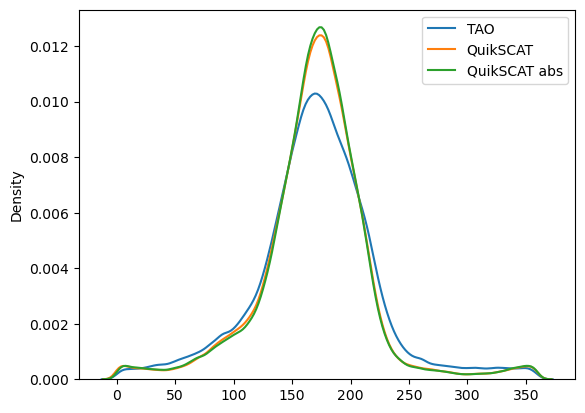

In [22]:
sns.kdeplot(df['WDIR (TAO)'], label = 'TAO',)
sns.kdeplot(df['WDIR (QuikSCAT)'], label = 'QuikSCAT')
sns.kdeplot(df['WDIR (QuikSCAT) absolute'], label = 'QuikSCAT abs')
plt.legend()

In [23]:
df

<xarray.Dataset> Size: 238MB
Dimensions:                                   (count: 266786)
Coordinates:
  * count                                     (count) int64 2MB 0 1 ... 298063
Data variables: (12/121)
    WDIR (TAO)                                (count) float32 1MB 140.6 ... 1...
    WDIR_QC                                   (count) float32 1MB 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 267kB b'D' ... b'D'
    WSPD (TAO)                                (count) float32 1MB 6.79 ... 4.23
    WSPD_QC                                   (count) float32 1MB 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 267kB b'D' ... b'D'
    ...                                        ...
    VWND_DIFF (QuikSCAT - TAO)                (count) float64 2MB -0.1175 ......
    WDIR_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB 1.2 ... -30.95
    cos(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.9998 ... ...
    sin(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 2MB 0.02094 ......
    UWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.07678 .....
    VWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 2MB -0.1377 ......

In [24]:
df.to_netcdf('rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_withoutManualRemovedSomeData.nc')